In [1]:
#1. import process
#import file located on the desktop - csv downloaded from the website
#translating into english the columns I'll use later in the program
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

db_elec = pd.read_csv("C:/Users/bbebe/Desktop/electricity_database_full.csv", sep=';')
db_elec = db_elec.rename(columns={
    "Jour" : "Date", 
    'Mois':'Month', 
    'Puissance moyenne journalière des consommations totales (W)':'Total Mean Consumption',
    'Température moyenne journalière réalisée lissée (°C)':'Daily Mean temperature (°C)',
    'Pseudo rayonnement':'pseudo radiation'
    })
print(db_elec.head())
print(db_elec.info())

         Date  Month  Puissance moyenne journalière de l'injection RTE (W)  \
0  2017-03-24      3                                       4.338725e+10      
1  2017-03-26      3                                       3.326324e+10      
2  2017-04-04      4                                       3.789645e+10      
3  2017-04-07      4                                       3.800531e+10      
4  2017-04-13      4                                       3.624013e+10      

   Puissance moyenne journalière du refoulement RTE (W)  \
0                                       1.177064e+09      
1                                       1.188863e+09      
2                                       8.146402e+08      
3                                       5.671506e+08      
4                                       7.270531e+08      

   Puissance moyenne journalière des pertes modélisées (W)  \
0                                       2.464725e+09         
1                                       2.027104e+09

In [2]:
#2. Index creation and sorting
#turn the date into datetime, make it the index and sort it ascending
db_elec['Date'] = pd.to_datetime(db_elec['Date'])
db_elec_sorted = db_elec.sort_values(by='Date')
db_elec_sorted.index = db_elec_sorted['Date']
print(db_elec_sorted.head())

                 Date  Month  \
Date                           
2017-03-12 2017-03-12      3   
2017-03-13 2017-03-13      3   
2017-03-14 2017-03-14      3   
2017-03-15 2017-03-15      3   
2017-03-16 2017-03-16      3   

            Puissance moyenne journalière de l'injection RTE (W)  \
Date                                                               
2017-03-12                                       3.494026e+10      
2017-03-13                                       4.069860e+10      
2017-03-14                                       4.212553e+10      
2017-03-15                                       4.140422e+10      
2017-03-16                                       3.983995e+10      

            Puissance moyenne journalière du refoulement RTE (W)  \
Date                                                               
2017-03-12                                        887384729.0      
2017-03-13                                        876864000.0      
2017-03-14                

In [3]:
#3. Data cleaning
#from step 1 and the info() function, I can see that the 'pseudo radiation' is having null values. populating them with 0
db_elec_sorted['pseudo radiation'] = db_elec_sorted['pseudo radiation'].fillna(0)
print(db_elec_sorted.info())

# add 2 columns for the year and day, based on the Date
db_elec_sorted['year']  = db_elec_sorted['Date'].dt.year
db_elec_sorted['Day']  = db_elec_sorted['Date'].dt.day

#simplify the dataframe by keeping only useful columns and filter it on year 2019
db_elec_slim =  db_elec_sorted[['Date', 'year', 'Month', 'Day', 'Total Mean Consumption', 'Daily Mean temperature (°C)', 'pseudo radiation']]
db_elec_2019 = db_elec_slim[db_elec_slim['year'] == 2019]
print(db_elec_2019)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2017-03-12 to 2022-03-11
Data columns (total 25 columns):
 #   Column                                                                                           Non-Null Count  Dtype         
---  ------                                                                                           --------------  -----         
 0   Date                                                                                             1826 non-null   datetime64[ns]
 1   Month                                                                                            1826 non-null   int64         
 2   Puissance moyenne journalière de l'injection RTE (W)                                             1826 non-null   float64       
 3   Puissance moyenne journalière du refoulement RTE (W)                                             1826 non-null   float64       
 4   Puissance moyenne journalière des pertes modélisées (W)                 

In [4]:
#4.Grouping and merge (2019)
#create a grouped version of the 2019 dataframe
#by month, calculating the average temperature, the average daily consumption, and the total consumption
db_elec_grouped = db_elec_2019.groupby('Month').agg(
    {'Total Mean Consumption': ['mean', 'sum'], 
     'Daily Mean temperature (°C)': 'mean'})

# Merge the calculated agg values to the initial daily dataframe, joining on its month
db_elec_2019_plus = pd.merge(db_elec_2019, db_elec_grouped, on='Month', how='left')
print(db_elec_2019_plus.info())

#renaming the name of the 3 new columns
db_elec_2019_plus.columns.values[7] = "Mean Monthly Consumption"
db_elec_2019_plus.columns.values[8] = "Total Monthly Consumption"
db_elec_2019_plus.columns.values[9] = "Mean Monthly Temperature"

print(db_elec_2019_plus.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Date                                 365 non-null    datetime64[ns]
 1   year                                 365 non-null    int64         
 2   Month                                365 non-null    int64         
 3   Day                                  365 non-null    int64         
 4   Total Mean Consumption               365 non-null    float64       
 5   Daily Mean temperature (°C)          365 non-null    float64       
 6   pseudo radiation                     365 non-null    float64       
 7   (Total Mean Consumption, mean)       365 non-null    float64       
 8   (Total Mean Consumption, sum)        365 non-null    float64       
 9   (Daily Mean temperature (°C), mean)  365 non-null    float64       
dtypes: datetime64[

C:\Users\bbebe\AppData\Local\Temp/ipykernel_9572/3714383051.py:8: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  db_elec_2019_plus = pd.merge(db_elec_2019, db_elec_grouped, on='Month', how='left')


In [5]:
#5. loop : assign a temperature event to a date based on its temperature
#print the dates with such an event
temp_event = []
for i in db_elec_slim['Daily Mean temperature (°C)'] :
    if i < 3:
        temp_event.append('Cold snap')
    elif i >= 24:
        temp_event.append('Heatwave')
    else :
        temp_event.append('Normal')

db_elec_slim['Temp_event'] = temp_event

db_test = db_elec_slim.loc[db_elec_slim['Temp_event'] != 'Normal', ['Date', 'Daily Mean temperature (°C)', 'Temp_event']]
print(db_test)
#print(db_elec_slim)

                 Date  Daily Mean temperature (°C) Temp_event
Date                                                         
2017-06-19 2017-06-19                         24.4   Heatwave
2017-06-20 2017-06-20                         25.5   Heatwave
2017-06-21 2017-06-21                         26.2   Heatwave
2017-06-22 2017-06-22                         26.1   Heatwave
2017-06-23 2017-06-23                         24.3   Heatwave
...               ...                          ...        ...
2022-01-15 2022-01-15                          2.5  Cold snap
2022-01-16 2022-01-16                          2.4  Cold snap
2022-01-25 2022-01-25                          2.7  Cold snap
2022-01-26 2022-01-26                          2.5  Cold snap
2022-01-27 2022-01-27                          2.8  Cold snap

[89 rows x 3 columns]


C:\Users\bbebe\AppData\Local\Temp/ipykernel_9572/3608315402.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_elec_slim['Temp_event'] = temp_event


In [6]:
#6. grouping and merge (all years)
#by month, calculating the average temperature, the average daily consumption, and the total consumption
db_elec_grouped_allyears = db_elec_slim.groupby(['year', 'Month']).agg(
    {'Total Mean Consumption': ['mean', 'sum'], 
     'Daily Mean temperature (°C)': 'mean'})

# Merge the calculated agg values to the initial daily dataframe, joining on its year and month
db_elec_slim_allyears = pd.merge(db_elec_slim, db_elec_grouped_allyears, on=['year','Month'], how='left')
print(db_elec_slim_allyears.info())

#renaming the name of the 3 new columns
db_elec_slim_allyears.columns.values[8] = "Mean Monthly Consumption"
db_elec_slim_allyears.columns.values[9] = "Total Monthly Consumption"
db_elec_slim_allyears.columns.values[10] = "Mean Monthly Temperature"

print(db_elec_slim_allyears.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1825
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Date                                 1826 non-null   datetime64[ns]
 1   year                                 1826 non-null   int64         
 2   Month                                1826 non-null   int64         
 3   Day                                  1826 non-null   int64         
 4   Total Mean Consumption               1826 non-null   float64       
 5   Daily Mean temperature (°C)          1826 non-null   float64       
 6   pseudo radiation                     1826 non-null   float64       
 7   Temp_event                           1826 non-null   object        
 8   (Total Mean Consumption, mean)       1826 non-null   float64       
 9   (Total Mean Consumption, sum)        1826 non-null   float64       
 10  (Daily Mean 

C:\Users\bbebe\AppData\Local\Temp/ipykernel_9572/772820729.py:8: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  db_elec_slim_allyears = pd.merge(db_elec_slim, db_elec_grouped_allyears, on=['year','Month'], how='left')


In [7]:
#7. Numpy 
#create an array out of the daily consumption, then calculate a few numpy variables
import numpy as np
mean_consumption_array = db_elec_2019_plus[['Total Mean Consumption']].to_numpy()
#print(mean_consumption_array)

print('shape : ', mean_consumption_array.shape)
#all 365 daily values are present in this array

#calculation of the mean, median and standard deviation of the daily consumption
print('mean : ', np.mean(mean_consumption_array))
print('median : ',np.median(mean_consumption_array))
print('std : ',np.std(mean_consumption_array))

shape :  (365, 1)
mean :  39220240185.715065
median :  36824477819.0
std :  8731338287.372038


In [8]:
#8. custom function
#creation of a function that saves directly a graph or a plot in a specified folder with a naming convention

def save_graph(filename) :
    path = "C:/Users/bbebe/Desktop/Data Certificate/"
    plt.savefig(path + filename + '.png')
    return

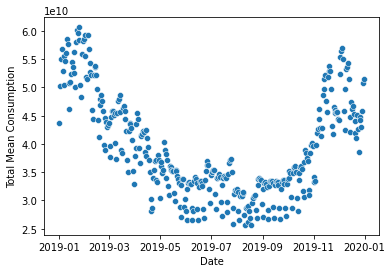

In [9]:
#9. data visualisation
#visualisation charts using seaborn and matplotlib
#index is used as a proxy for date on the x axis
#function to automatically save graph in a given folder

import matplotlib.pyplot as plt
import seaborn as sns

#first visualisation of the daily consumption per day, with dates on the axis
sns.scatterplot(data = db_elec_2019_plus, x='Date', y='Total Mean Consumption')
save_graph('scatterplot_2019')
plt.show()

#this basic graph plots the daily consumption on a time axis. 
#It shows naturally a higher consumption of electricity during winter months, up to twice the quantity of summer ones

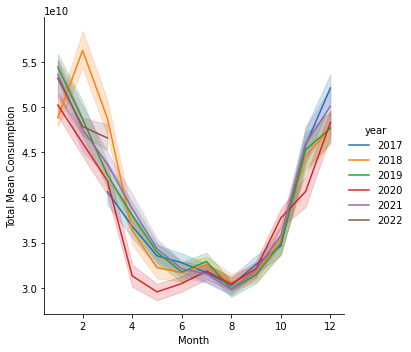

In [10]:
#second visualisation is comparaison of the monthly consumption year by year
sns.color_palette("tab10")
sns.relplot(data = db_elec_slim_allyears, x='Month', y='Total Mean Consumption', hue='year', kind='line', palette="tab10")
save_graph('relplot_allyears')
plt.show()

#no significant variation on yearly consumption patterns, except the 2018 cold snap and the first 2020 covid lockdown is visible though

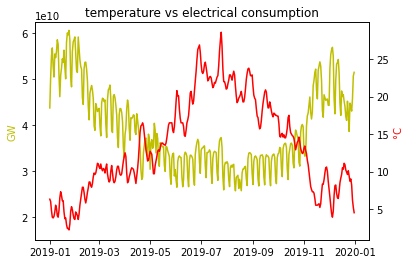

In [11]:
#use of matplotlib to set 2 axis, consumption versus temperature

x = db_elec_2019_plus['Date']
y1 = db_elec_2019_plus['Total Mean Consumption']
y2 = db_elec_2019_plus['Daily Mean temperature (°C)']

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(x, y1, 'y')
ax2.plot(x, y2, 'r')

ax.set_title('temperature vs electrical consumption')
ax.set_ylabel('GW', color='y')
ax.set_ylim(ymin = 15000000000)
ax2.set_ylabel('°C', color='r')

save_graph('pyplot_2019')
plt.show()

#the negative correlation between temperature and electric consumption appears here

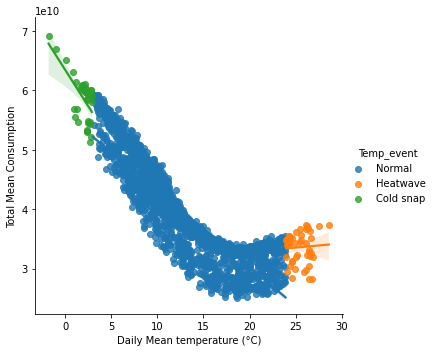

In [12]:
#plotting the relationship between temperature and total consumption, with a regression line
sns.color_palette("tab10")
sns.lmplot(data = db_elec_slim, x='Daily Mean temperature (°C)', y='Total Mean Consumption', hue='Temp_event', palette="tab10")
save_graph('lmplot_allyears')
plt.show()

# in these cases the correlation between temperature and electrical consumption is more obvious
# it's almost a perfect negative correclation on the colder side, breaks around 15-20 degres and turns positively correlated from 20c

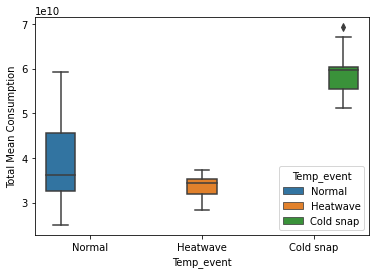

In [13]:
#boxplot of the daily consumption depending on the type of climate event (cold snap, normal, heatwave)

sns.color_palette("tab10")
sns.boxplot(data=db_elec_slim, x='Temp_event', y='Total Mean Consumption', hue='Temp_event', palette="tab10", whis=1.5)
save_graph('boxplot_allyears')
plt.show()